<a href="https://colab.research.google.com/github/Tiara-la/stacking-p2p-lending/blob/main/onProsperExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile,os
import pandas as pd
import numpy as np

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

# **Data Collection**

## **Kaggle**

In [11]:
# install the Kaggle API client
! pip install -q kaggle

In [12]:
# Unggah file kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"tiaralailatulnikmah","key":"1a294e2d607cef4fb50b5cd7366998e0"}'}

In [13]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d skihikingkevin/online-p2p-lending

online-p2p-lending.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
# melakukan unzip pada dataset yang telah di download

import zipfile,os
local_zip = '/content/online-p2p-lending.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

## **Data Import**

In [16]:
# membaca dataset
df = pd.read_csv('/tmp/Master_Loan_Summary.csv',  delimiter=',')
df

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,loan_number,amount_borrowed,term,borrower_rate,installment,grade,origination_date,listing_title,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,last_payment_date,next_payment_due_date,days_past_due,loan_status_description,data_source
0,10149342,27050.0,36,0.1099,885.460000,B,2013-12-01T00:00,debt_consolidation,0.00,27050.00,4702.53,0.0,0.0,2016-07-01T00:00,2016-08-01T00:00,0,COMPLETED,Lending Club
1,10149488,4800.0,36,0.1099,157.130000,B,2013-12-01T00:00,home_improvement,0.00,4800.00,357.52,0.0,0.0,2014-09-01T00:00,2014-10-01T00:00,0,COMPLETED,Lending Club
2,10148122,12000.0,36,0.0762,373.940000,A,2013-12-01T00:00,debt_consolidation,0.00,12000.00,1397.54,0.0,0.0,2016-06-01T00:00,2016-07-01T00:00,0,COMPLETED,Lending Club
3,10119623,12000.0,36,0.1199,398.520000,B,2013-12-01T00:00,debt_consolidation,0.00,12000.00,2346.48,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club
4,10159498,12000.0,36,0.0662,368.450000,A,2013-12-01T00:00,debt_consolidation,0.00,12000.00,1263.95,0.0,0.0,2017-01-01T00:00,2017-02-01T00:00,0,COMPLETED,Lending Club
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875141,1081905,10000.0,36,0.0934,319.582092,B,2018-06-29,NaN,9667.17,332.83,86.75,0.0,0.0,2018-09-29,2018-08-29,0,CURRENT,Prosper
2875142,1081908,10000.0,36,0.1214,332.812163,C,2018-06-29,NaN,9766.97,233.03,99.78,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT,Prosper
2875143,1081947,4000.0,60,0.2455,116.352367,E,2018-06-29,NaN,3964.36,35.64,80.71,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT,Prosper
2875144,1081797,30000.0,60,0.1878,774.589469,D,2018-06-29,NaN,29688.48,311.52,463.07,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT,Prosper


In [17]:
# ambil data source dari Prosper
df = df[df['data_source'] == 'Prosper']
df

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,origination_date,listing_title,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,last_payment_date,next_payment_due_date,days_past_due,loan_status_description,data_source
1961527,80355,5000.0,36,0.2566,200.548615,E,2013-01-04,NaN,0.00,5000.00,1793.31,0.0,0.0,2015-07-04,2016-01-04,0,COMPLETED,Prosper
1961528,80708,15500.0,36,0.1679,550.998674,C,2013-01-04,NaN,0.00,15500.00,3452.00,0.0,0.0,2015-06-04,2016-01-04,0,COMPLETED,Prosper
1961529,80800,10000.0,60,0.2557,296.864320,E,2013-01-07,NaN,0.00,10000.00,4084.82,0.0,0.0,2015-09-07,2018-01-07,0,COMPLETED,Prosper
1961530,81062,15000.0,60,0.1752,376.995481,C,2013-01-07,NaN,0.00,15000.00,4133.78,0.0,0.0,2015-10-07,2018-01-07,0,COMPLETED,Prosper
1961531,80676,2500.0,36,0.0789,78.214113,A,2013-01-07,NaN,0.00,2499.99,228.74,0.0,0.0,2015-04-07,2016-01-07,0,COMPLETED,Prosper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875141,1081905,10000.0,36,0.0934,319.582092,B,2018-06-29,NaN,9667.17,332.83,86.75,0.0,0.0,2018-09-29,2018-08-29,0,CURRENT,Prosper
2875142,1081908,10000.0,36,0.1214,332.812163,C,2018-06-29,NaN,9766.97,233.03,99.78,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT,Prosper
2875143,1081947,4000.0,60,0.2455,116.352367,E,2018-06-29,NaN,3964.36,35.64,80.71,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT,Prosper
2875144,1081797,30000.0,60,0.1878,774.589469,D,2018-06-29,NaN,29688.48,311.52,463.07,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT,Prosper


In [18]:
# hapus fitur data source karena sudah tidak diperlukan
df = df.drop(['data_source'], axis=1)
df

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,origination_date,listing_title,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,last_payment_date,next_payment_due_date,days_past_due,loan_status_description
1961527,80355,5000.0,36,0.2566,200.548615,E,2013-01-04,NaN,0.00,5000.00,1793.31,0.0,0.0,2015-07-04,2016-01-04,0,COMPLETED
1961528,80708,15500.0,36,0.1679,550.998674,C,2013-01-04,NaN,0.00,15500.00,3452.00,0.0,0.0,2015-06-04,2016-01-04,0,COMPLETED
1961529,80800,10000.0,60,0.2557,296.864320,E,2013-01-07,NaN,0.00,10000.00,4084.82,0.0,0.0,2015-09-07,2018-01-07,0,COMPLETED
1961530,81062,15000.0,60,0.1752,376.995481,C,2013-01-07,NaN,0.00,15000.00,4133.78,0.0,0.0,2015-10-07,2018-01-07,0,COMPLETED
1961531,80676,2500.0,36,0.0789,78.214113,A,2013-01-07,NaN,0.00,2499.99,228.74,0.0,0.0,2015-04-07,2016-01-07,0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875141,1081905,10000.0,36,0.0934,319.582092,B,2018-06-29,NaN,9667.17,332.83,86.75,0.0,0.0,2018-09-29,2018-08-29,0,CURRENT
2875142,1081908,10000.0,36,0.1214,332.812163,C,2018-06-29,NaN,9766.97,233.03,99.78,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT
2875143,1081947,4000.0,60,0.2455,116.352367,E,2018-06-29,NaN,3964.36,35.64,80.71,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT
2875144,1081797,30000.0,60,0.1878,774.589469,D,2018-06-29,NaN,29688.48,311.52,463.07,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT


In [19]:
# atur indexing dataset
df = df.reset_index(drop=True)
df

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,origination_date,listing_title,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,last_payment_date,next_payment_due_date,days_past_due,loan_status_description
0,80355,5000.0,36,0.2566,200.548615,E,2013-01-04,NaN,0.00,5000.00,1793.31,0.0,0.0,2015-07-04,2016-01-04,0,COMPLETED
1,80708,15500.0,36,0.1679,550.998674,C,2013-01-04,NaN,0.00,15500.00,3452.00,0.0,0.0,2015-06-04,2016-01-04,0,COMPLETED
2,80800,10000.0,60,0.2557,296.864320,E,2013-01-07,NaN,0.00,10000.00,4084.82,0.0,0.0,2015-09-07,2018-01-07,0,COMPLETED
3,81062,15000.0,60,0.1752,376.995481,C,2013-01-07,NaN,0.00,15000.00,4133.78,0.0,0.0,2015-10-07,2018-01-07,0,COMPLETED
4,80676,2500.0,36,0.0789,78.214113,A,2013-01-07,NaN,0.00,2499.99,228.74,0.0,0.0,2015-04-07,2016-01-07,0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913614,1081905,10000.0,36,0.0934,319.582092,B,2018-06-29,NaN,9667.17,332.83,86.75,0.0,0.0,2018-09-29,2018-08-29,0,CURRENT
913615,1081908,10000.0,36,0.1214,332.812163,C,2018-06-29,NaN,9766.97,233.03,99.78,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT
913616,1081947,4000.0,60,0.2455,116.352367,E,2018-06-29,NaN,3964.36,35.64,80.71,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT
913617,1081797,30000.0,60,0.1878,774.589469,D,2018-06-29,NaN,29688.48,311.52,463.07,0.0,0.0,2018-08-29,2018-08-29,0,CURRENT


# **Exploratory Data Analysis**

In [20]:
# info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913619 entries, 0 to 913618
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_number                  913619 non-null  int64  
 1   amount_borrowed              913619 non-null  float64
 2   term                         913619 non-null  int64  
 3   borrower_rate                913619 non-null  float64
 4   installment                  913619 non-null  float64
 5   grade                        913619 non-null  object 
 6   origination_date             913619 non-null  object 
 7   listing_title                50541 non-null   object 
 8   principal_balance            913619 non-null  float64
 9   principal_paid               913619 non-null  float64
 10  interest_paid                913619 non-null  float64
 11  late_fees_paid               913619 non-null  float64
 12  debt_sale_proceeds_received  913619 non-null  float64
 13 

In [21]:
# deskripsi data
df.describe()

,loan_number,amount_borrowed,term,borrower_rate,installment,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,days_past_due
count,9.136190e+05,913619.000000,913619.000000,913619.000000,913619.000000,913619.000000,913619.000000,913619.000000,913619.000000,913619.0,913619.000000
mean,5.821678e+05,13332.617882,43.128871,0.153106,407.563923,4307.853990,8104.099338,2142.619795,5.808205,0.0,15.807546
std,2.858683e+05,7946.272924,10.982495,0.065643,235.237354,6514.352055,7514.961075,2073.576736,34.922043,0.0,109.942776
min,7.965000e+04,2000.000000,12.000000,0.053100,40.066394,0.000000,-15.000000,-8.255100,0.000000,0.0,0.000000
25%,3.309195e+05,7500.000000,36.000000,0.103900,231.905584,0.000000,2198.805000,702.335000,0.000000,0.0,0.000000
50%,5.946240e+05,12000.000000,36.000000,0.137500,361.373478,0.000000,5722.420000,1497.500000,0.000000,0.0,0.000000
75%,8.324515e+05,18000.000000,60.000000,0.192000,531.325392,7162.990000,12000.000000,2875.450000,0.000000,0.0,0.000000
max,1.081986e+06,40000.000000,60.000000,0.319200,2251.506148,39546.430000,40000.000000,18575.600000,1676.850000,0.0,2029.000000


<AxesSubplot:xlabel='loan_status_description', ylabel='count'>

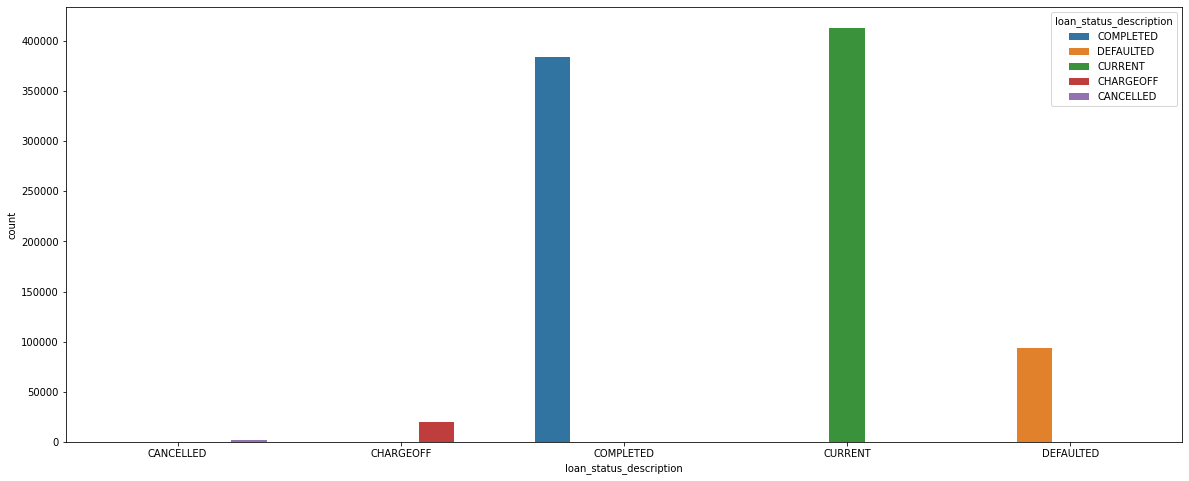

In [22]:
plt.figure(figsize=(20, 8))

uniq = df['loan_status_description'].astype(str).unique()
grade = sorted(uniq.tolist())
sns.countplot(x='loan_status_description', data=df, hue='loan_status_description', order=grade)

<AxesSubplot:>

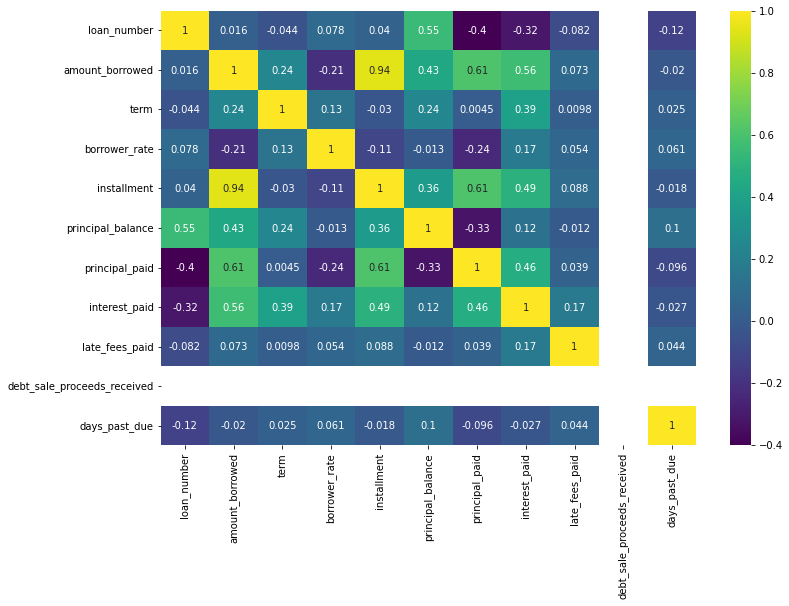

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

installment memiliki korelasi baik dengan amount_borrowed

# **Preprocessing Data**

## **Data Cleaning: Missing Values Check**



In [24]:
#preprocessing data
#cek mising value nilai Null
df.isnull().sum() 

loan_number                         0
amount_borrowed                     0
term                                0
borrower_rate                       0
installment                         0
grade                               0
origination_date                    0
listing_title                  863078
principal_balance                   0
principal_paid                      0
interest_paid                       0
late_fees_paid                      0
debt_sale_proceeds_received         0
last_payment_date                   0
next_payment_due_date               0
days_past_due                       0
loan_status_description             0
dtype: int64

In [25]:
# The length of the data
print(f"The Length of the data: {df.shape}")

The Length of the data: (913619, 17)


In [26]:
# Missing values nilai NaN
for column in df.columns:
    if df[column].isna().sum() != 0:
        missing = df[column].isna().sum()
        portion = (missing / df.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'listing_title': number of missing values '863078' ==> '94.468%'


In [27]:
# hapus kolom yang meiliki missing value diatas 30%
df = df.drop(['listing_title'], axis=1)

In [28]:
# cek ulang missing value setelah dihapus
df.isna().sum()

loan_number                    0
amount_borrowed                0
term                           0
borrower_rate                  0
installment                    0
grade                          0
origination_date               0
principal_balance              0
principal_paid                 0
interest_paid                  0
late_fees_paid                 0
debt_sale_proceeds_received    0
last_payment_date              0
next_payment_due_date          0
days_past_due                  0
loan_status_description        0
dtype: int64

## **Data Cleaning: Outlier Check**

### **amount_borrowed**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


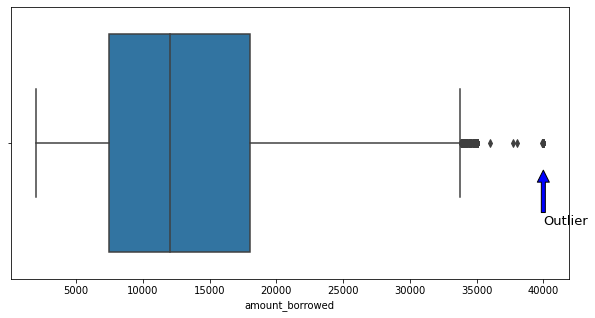

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['amount_borrowed'])
plt.annotate('Outlier', (df['amount_borrowed'].describe()['max'],0.1), xytext = (df['amount_borrowed'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['amount_borrowed'].describe()['75%'] - df['amount_borrowed'].describe()['25%']

In [30]:
# Q1, Q3, dan IQR
Q1 = df['amount_borrowed'].quantile(0.25)
Q3 = df['amount_borrowed'].quantile(0.75)
IQR = Q3 - Q1

In [31]:
# Removing outliers
df = df[~((df['amount_borrowed'] < (Q1-1.5*IQR)) | (df['amount_borrowed'] > (Q3+1.5*IQR)))]


In [32]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (883499, 16)


### **borrower_rate**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


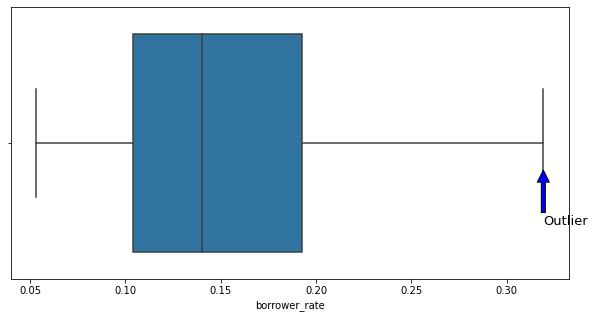

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['borrower_rate'])
plt.annotate('Outlier', (df['borrower_rate'].describe()['max'],0.1), xytext = (df['borrower_rate'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['borrower_rate'].describe()['75%'] - df['borrower_rate'].describe()['25%']

In [34]:
# Q1, Q3, dan IQR
Q1 = df['borrower_rate'].quantile(0.25)
Q3 = df['borrower_rate'].quantile(0.75)
IQR = Q3 - Q1

In [35]:
# Removing outliers
df = df[~((df['borrower_rate'] < (Q1-1.5*IQR)) | (df['borrower_rate'] > (Q3+1.5*IQR)))]


In [36]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (883499, 16)


### **installment**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


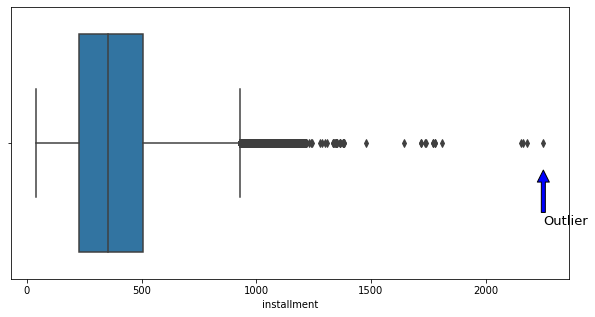

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['installment'])
plt.annotate('Outlier', (df['installment'].describe()['max'],0.1), xytext = (df['installment'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['installment'].describe()['75%'] - df['installment'].describe()['25%']

In [38]:
# Q1, Q3, dan IQR
Q1 = df['installment'].quantile(0.25)
Q3 = df['installment'].quantile(0.75)
IQR = Q3 - Q1

In [39]:
# Removing outliers
df = df[~((df['installment'] < (Q1-1.5*IQR)) | (df['installment'] > (Q3+1.5*IQR)))]


In [40]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (866490, 16)


### **principal_balance**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


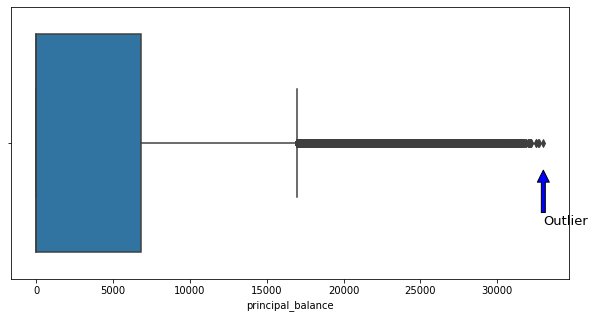

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['principal_balance'])
plt.annotate('Outlier', (df['principal_balance'].describe()['max'],0.1), xytext = (df['principal_balance'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['principal_balance'].describe()['75%'] - df['principal_balance'].describe()['25%']

In [42]:
# Q1, Q3, dan IQR
Q1 = df['principal_balance'].quantile(0.25)
Q3 = df['principal_balance'].quantile(0.75)
IQR = Q3 - Q1

In [43]:
# Removing outliers
df = df[~((df['principal_balance'] < (Q1-1.5*IQR)) | (df['principal_balance'] > (Q3+1.5*IQR)))]


In [44]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (830829, 16)


### **principal_paid**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


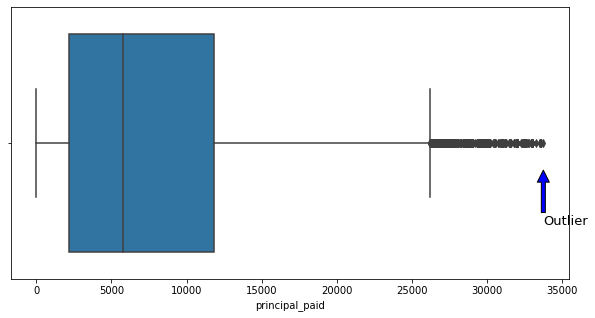

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['principal_paid'])
plt.annotate('Outlier', (df['principal_paid'].describe()['max'],0.1), xytext = (df['principal_paid'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['principal_paid'].describe()['75%'] - df['principal_paid'].describe()['25%']

In [46]:
# Q1, Q3, dan IQR
Q1 = df['principal_paid'].quantile(0.25)
Q3 = df['principal_paid'].quantile(0.75)
IQR = Q3 - Q1

In [47]:
# Removing outliers
df = df[~((df['principal_paid'] < (Q1-1.5*IQR)) | (df['principal_paid'] > (Q3+1.5*IQR)))]


In [48]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (824797, 16)


### **Interest_paid**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


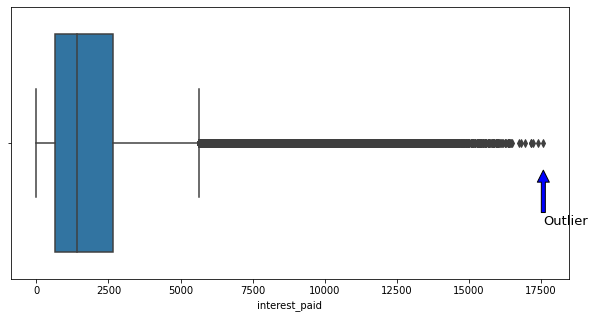

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['interest_paid'])
plt.annotate('Outlier', (df['interest_paid'].describe()['max'],0.1), xytext = (df['interest_paid'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['interest_paid'].describe()['75%'] - df['interest_paid'].describe()['25%']

In [50]:
# Q1, Q3, dan IQR
Q1 = df['interest_paid'].quantile(0.25)
Q3 = df['interest_paid'].quantile(0.75)
IQR = Q3 - Q1

In [51]:
# Removing outliers
df = df[~((df['interest_paid'] < (Q1-1.5*IQR)) | (df['interest_paid'] > (Q3+1.5*IQR)))]


In [52]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (779042, 16)


### **late_fees_paid**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


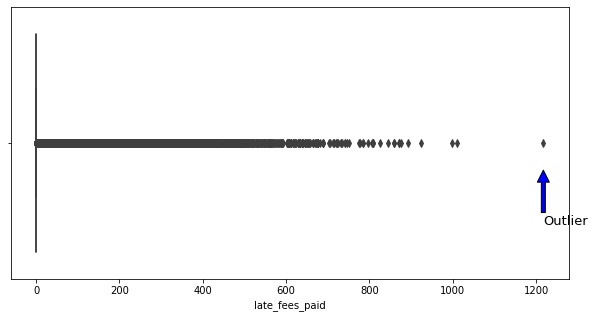

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['late_fees_paid'])
plt.annotate('Outlier', (df['late_fees_paid'].describe()['max'],0.1), xytext = (df['late_fees_paid'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['late_fees_paid'].describe()['75%'] - df['late_fees_paid'].describe()['25%']

In [54]:
# Q1, Q3, dan IQR
Q1 = df['late_fees_paid'].quantile(0.25)
Q3 = df['late_fees_paid'].quantile(0.75)
IQR = Q3 - Q1

In [55]:
# Removing outliers
df = df[~((df['late_fees_paid'] < (Q1-1.5*IQR)) | (df['late_fees_paid'] > (Q3+1.5*IQR)))]


In [56]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (727131, 16)


### **debt_sale_proceeds_received**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


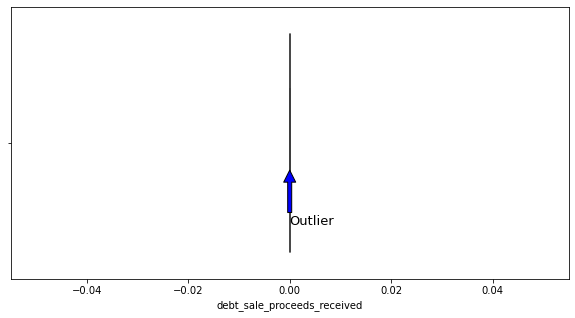

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['debt_sale_proceeds_received'])
plt.annotate('Outlier', (df['debt_sale_proceeds_received'].describe()['max'],0.1), xytext = (df['debt_sale_proceeds_received'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['debt_sale_proceeds_received'].describe()['75%'] - df['debt_sale_proceeds_received'].describe()['25%']

In [58]:
# Q1, Q3, dan IQR
Q1 = df['debt_sale_proceeds_received'].quantile(0.25)
Q3 = df['debt_sale_proceeds_received'].quantile(0.75)
IQR = Q3 - Q1

In [59]:
# Removing outliers
df = df[~((df['debt_sale_proceeds_received'] < (Q1-1.5*IQR)) | (df['debt_sale_proceeds_received'] > (Q3+1.5*IQR)))]


In [60]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (727131, 16)


### **term**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


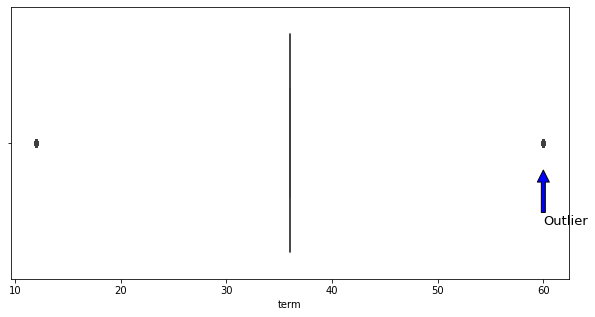

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['term'])
plt.annotate('Outlier', (df['term'].describe()['max'],0.1), xytext = (df['term'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['term'].describe()['75%'] - df['term'].describe()['25%']

In [62]:
# Q1, Q3, dan IQR
Q1 = df['term'].quantile(0.25)
Q3 = df['term'].quantile(0.75)
IQR = Q3 - Q1

In [63]:
# Removing outliers
df = df[~((df['term'] < (Q1-1.5*IQR)) | (df['term'] > (Q3+1.5*IQR)))]


In [64]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (549838, 16)


### **days_past_due**

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


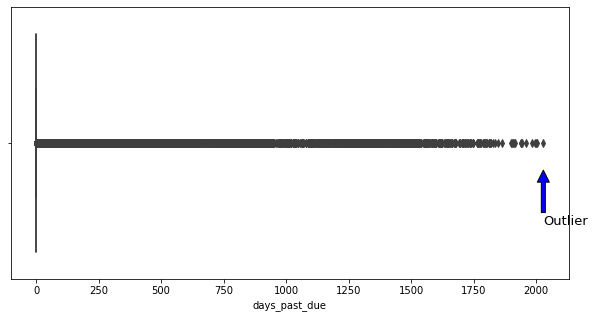

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10, 5))
sns.boxplot(df['days_past_due'])
plt.annotate('Outlier', (df['days_past_due'].describe()['max'],0.1), xytext = (df['days_past_due'].describe()['max'],0.3),
             arrowprops = dict(facecolor = 'blue'), fontsize = 13 )
IQR = df['days_past_due'].describe()['75%'] - df['days_past_due'].describe()['25%']

In [66]:
# Q1, Q3, dan IQR
Q1 = df['days_past_due'].quantile(0.25)
Q3 = df['days_past_due'].quantile(0.75)
IQR = Q3 - Q1

In [67]:
# Removing outliers
df = df[~((df['days_past_due'] < (Q1-1.5*IQR)) | (df['days_past_due'] > (Q3+1.5*IQR)))]


In [68]:
# Check ukuran (baris dan kolom) setelah data yang outliers dibuang
print('Shape akhir: ', df.shape)

Shape akhir:  (525401, 16)


## **Data Cleaning: Removing Features Unused**

In [69]:
print("Jumlah unique value fitur last_payment_date:", len(df["last_payment_date"].unique()))
print("Jumlah unique value fitur next_payment_due_date:", len(df["next_payment_due_date"].unique()))
print("Jumlah unique value fitur origination_date:", len(df["origination_date"].unique()))
print("Jumlah unique value fitur late_fees_paid:", len(df["late_fees_paid"].unique()))
print("Jumlah unique value fitur days_past_due:", len(df["days_past_due"].unique()))

Jumlah unique value fitur last_payment_date: 2195
Jumlah unique value fitur next_payment_due_date: 1703
Jumlah unique value fitur origination_date: 1381
Jumlah unique value fitur late_fees_paid: 1
Jumlah unique value fitur days_past_due: 1


In [70]:
# menghapus fitur yang tidak digunakan
# fitur terlalu banyak nilai unique
df = df.drop(['last_payment_date', 'next_payment_due_date', 'origination_date'], axis=1)
df

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,days_past_due,loan_status_description
0,80355,5000.00,36,0.2566,200.548615,E,0.00,5000.00,1793.31,0.0,0.0,0,COMPLETED
1,80708,15500.00,36,0.1679,550.998674,C,0.00,15500.00,3452.00,0.0,0.0,0,COMPLETED
4,80676,2500.00,36,0.0789,78.214113,A,0.00,2499.99,228.74,0.0,0.0,0,COMPLETED
5,82158,3983.31,36,0.2859,166.036273,F,0.00,3983.30,1582.13,0.0,0.0,0,COMPLETED
6,81659,5000.00,36,0.2566,200.548615,E,0.00,5000.00,1598.26,0.0,0.0,0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913611,1081977,11400.00,36,0.0964,365.922141,B,11124.41,275.59,90.33,0.0,0.0,0,CURRENT
913612,1081968,9800.00,36,0.0531,295.080729,A,9547.69,252.31,42.77,0.0,0.0,0,CURRENT
913614,1081905,10000.00,36,0.0934,319.582092,B,9667.17,332.83,86.75,0.0,0.0,0,CURRENT
913615,1081908,10000.00,36,0.1214,332.812163,C,9766.97,233.03,99.78,0.0,0.0,0,CURRENT


# **Encoder**

In [71]:
# fitur yang akan di encode
label_encode = ['grade']

In [72]:
from sklearn.preprocessing import LabelEncoder
# label_encoder object knows how to understand word labels. 
label_encoder = LabelEncoder()
# Encode labels in column 'grade'. 
df[label_encode] =df[label_encode].apply(LabelEncoder().fit_transform)

In [73]:
df

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,days_past_due,loan_status_description
0,80355,5000.00,36,0.2566,200.548615,4,0.00,5000.00,1793.31,0.0,0.0,0,COMPLETED
1,80708,15500.00,36,0.1679,550.998674,2,0.00,15500.00,3452.00,0.0,0.0,0,COMPLETED
4,80676,2500.00,36,0.0789,78.214113,0,0.00,2499.99,228.74,0.0,0.0,0,COMPLETED
5,82158,3983.31,36,0.2859,166.036273,5,0.00,3983.30,1582.13,0.0,0.0,0,COMPLETED
6,81659,5000.00,36,0.2566,200.548615,4,0.00,5000.00,1598.26,0.0,0.0,0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913611,1081977,11400.00,36,0.0964,365.922141,1,11124.41,275.59,90.33,0.0,0.0,0,CURRENT
913612,1081968,9800.00,36,0.0531,295.080729,0,9547.69,252.31,42.77,0.0,0.0,0,CURRENT
913614,1081905,10000.00,36,0.0934,319.582092,1,9667.17,332.83,86.75,0.0,0.0,0,CURRENT
913615,1081908,10000.00,36,0.1214,332.812163,2,9766.97,233.03,99.78,0.0,0.0,0,CURRENT


In [74]:
# melihat nilai unique dari loan_status
df['loan_status_description'].unique()

array(['COMPLETED', 'CURRENT', 'DEFAULTED', 'CANCELLED'], dtype=object)

In [75]:
# melihat jumlah setiap nilai unique
df["loan_status_description"].value_counts()

COMPLETED    267040
CURRENT      218247
DEFAULTED     38719
CANCELLED      1395
Name: loan_status_description, dtype: int64

In [76]:
# encode nilai loan_status menjadi 0 dan 1
cleanup_nums = {"loan_status_description":     {"CURRENT": 0, "COMPLETED": 0, "DEFAULTED": 1, "CHARGEOFF": 1, "CANCELLED": 1}}

In [77]:
# replace berdasarkan variabel encode
df = df.replace(cleanup_nums)
df.head()

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,days_past_due,loan_status_description
0,80355,5000.00,36,0.2566,200.548615,4,0.0,5000.00,1793.31,0.0,0.0,0,0
1,80708,15500.00,36,0.1679,550.998674,2,0.0,15500.00,3452.00,0.0,0.0,0,0
4,80676,2500.00,36,0.0789,78.214113,0,0.0,2499.99,228.74,0.0,0.0,0,0
5,82158,3983.31,36,0.2859,166.036273,5,0.0,3983.30,1582.13,0.0,0.0,0,0
6,81659,5000.00,36,0.2566,200.548615,4,0.0,5000.00,1598.26,0.0,0.0,0,0


In [78]:
# atur indexing data
df = df.reset_index(drop=True)
df

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,principal_balance,principal_paid,interest_paid,late_fees_paid,debt_sale_proceeds_received,days_past_due,loan_status_description
0,80355,5000.00,36,0.2566,200.548615,4,0.00,5000.00,1793.31,0.0,0.0,0,0
1,80708,15500.00,36,0.1679,550.998674,2,0.00,15500.00,3452.00,0.0,0.0,0,0
2,80676,2500.00,36,0.0789,78.214113,0,0.00,2499.99,228.74,0.0,0.0,0,0
3,82158,3983.31,36,0.2859,166.036273,5,0.00,3983.30,1582.13,0.0,0.0,0,0
4,81659,5000.00,36,0.2566,200.548615,4,0.00,5000.00,1598.26,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525396,1081977,11400.00,36,0.0964,365.922141,1,11124.41,275.59,90.33,0.0,0.0,0,0
525397,1081968,9800.00,36,0.0531,295.080729,0,9547.69,252.31,42.77,0.0,0.0,0,0
525398,1081905,10000.00,36,0.0934,319.582092,1,9667.17,332.83,86.75,0.0,0.0,0,0
525399,1081908,10000.00,36,0.1214,332.812163,2,9766.97,233.03,99.78,0.0,0.0,0,0


# **SMOTE**

In [79]:
#over sampling data SMOTE
loan_data = df
X = loan_data.drop(['loan_status_description'], axis=1)
y = loan_data['loan_status_description']

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X,y)

loan_datas = X_sm
loan_datas['loan_status_description'] = y_sm

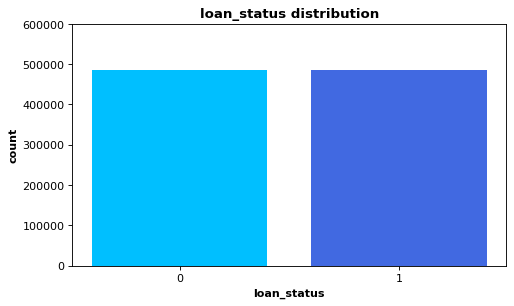

Data before over-sampling
0    485287
1     40114
Name: loan_status_description, dtype: int64 

Data after over-sampling
0    485287
1    485287
Name: loan_status_description, dtype: int64


In [85]:
#melihat hasil dari Over Sampling SMOTE
import numpy as np
import matplotlib.pyplot as plt
height = y_sm.value_counts()
labels = ( '0', '1')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600000)
plt.title('loan_status distribution', fontweight='bold')
plt.xlabel('loan_status', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue'])
plt.xticks(y_pos, labels)
plt.show()

print("Data before over-sampling")
print(df['loan_status_description'].value_counts(), "\n")

print("Data after over-sampling")
print(loan_datas['loan_status_description'].value_counts())

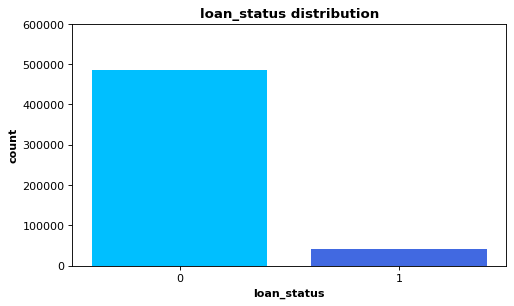

Data before over-sampling
0    485287
1     40114
Name: loan_status_description, dtype: int64 

Data after over-sampling
0    485287
1     40114
Name: loan_status_description, dtype: int64


In [86]:
#melihat hasil dari Over Sampling SMOTE
import numpy as np
import matplotlib.pyplot as plt
height = y.value_counts()
labels = ( '0', '1')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600000)
plt.title('loan_status distribution', fontweight='bold')
plt.xlabel('loan_status', fontweight='bold')
plt.ylabel('count', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue'])
plt.xticks(y_pos, labels)
plt.show()

print("Data before over-sampling")
print(df['loan_status_description'].value_counts(), "\n")

print("Data after over-sampling")
print(loan_data['loan_status_description'].value_counts())

# **Modelling**

In [ ]:
#import sklearn metric
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc)

In [ ]:
#confusion Metric
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [ ]:
# Pembagian X dan y
X = loan_datas.drop(['loan_status_description'], axis=1)
y = loan_datas['loan_status_description']

In [ ]:
X

,loan_number,amount_borrowed,term,borrower_rate,installment,grade,principal_balance,principal_paid,interest_paid
0,80355,5000.000000,36,0.256600,200.548615,4,0.0,5000.000000,1793.310000
1,80708,15500.000000,36,0.167900,550.998674,2,0.0,15500.000000,3452.000000
2,80676,2500.000000,36,0.078900,78.214113,0,0.0,2499.990000,228.740000
3,82158,3983.310000,36,0.285900,166.036273,5,0.0,3983.300000,1582.130000
4,81659,5000.000000,36,0.256600,200.548615,4,0.0,5000.000000,1598.260000
...,...,...,...,...,...,...,...,...,...
970569,139763,6166.894111,36,0.202777,232.311175,3,0.0,1762.672362,1195.283422
970570,193563,4199.853636,36,0.226726,161.561994,4,0.0,524.870851,458.343589
970571,592052,15000.000000,36,0.115489,495.058853,2,0.0,2009.434183,534.459813
970572,566252,13037.428966,36,0.200662,484.899788,3,0.0,810.077652,634.657890


## **XGBoost**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

clf3 = XGBClassifier()
svm = cross_val_score(clf3, X, y, cv=10, scoring = "accuracy")
for i in range(10):
  print("Akurasi dari SVM : {0:2%}". format(svm[i,]))
print("Rata-rata Akurasi dari SVM :", svm.mean())
print("Akurasi Terbaik: ", svm.max())
y_pred = cross_val_predict(clf3, X, y, cv=10)
cfm = confusion_matrix(y, y_pred)
print("Confusion Matrix: ", cfm)

Akurasi dari SVM : 98.760973%
Akurasi dari SVM : 99.059784%
Akurasi dari SVM : 99.252424%
Akurasi dari SVM : 99.010530%
Akurasi dari SVM : 99.186752%
Akurasi dari SVM : 98.955802%
Akurasi dari SVM : 99.168144%
Akurasi dari SVM : 99.191130%
Akurasi dari SVM : 98.967842%
Akurasi dari SVM : 98.373485%
Rata-rata Akurasi dari SVM : 0.9899268664596376
Akurasi Terbaik:  0.9925242442153193
Confusion Matrix:  [[796175   1251]
 [  7952 108241]]


## **Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

clf3 = RandomForestClassifier()
svm = cross_val_score(clf3, X, y, cv=10, scoring = "accuracy")
for i in range(10):
  print("Akurasi dari SVM : {0:2%}". format(svm[i,]))
print("Rata-rata Akurasi dari SVM :", svm.mean())
print("Akurasi Terbaik: ", svm.max())
y_pred = cross_val_predict(clf3, X, y, cv=10)
cfm = confusion_matrix(y, y_pred)
print("Confusion Matrix: ", cfm)

Akurasi dari SVM : 99.217399%
Akurasi dari SVM : 99.727458%
Akurasi dari SVM : 93.832228%
Akurasi dari SVM : 98.811322%
Akurasi dari SVM : 99.637705%
Akurasi dari SVM : 99.418796%
Akurasi dari SVM : 99.566559%
Akurasi dari SVM : 99.165955%
Akurasi dari SVM : 98.697489%
Akurasi dari SVM : 98.572695%
Rata-rata Akurasi dari SVM : 0.9866476059269186
Akurasi Terbaik:  0.9972745780521443
Confusion Matrix:  [[791799   5627]
 [  4229 111964]]


## **Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

clf3 = DecisionTreeClassifier()
svm = cross_val_score(clf3, X, y, cv=10, scoring = "accuracy")
for i in range(10):
  print("Akurasi dari SVM : {0:2%}". format(svm[i,]))
print("Rata-rata Akurasi dari SVM :", svm.mean())
print("Akurasi Terbaik: ", svm.max())
y_pred = cross_val_predict(clf3, X, y, cv=10)
cfm = confusion_matrix(y, y_pred)
print("Confusion Matrix: ", cfm)

Akurasi dari SVM : 99.257897%
Akurasi dari SVM : 92.969725%
Akurasi dari SVM : 87.808936%
Akurasi dari SVM : 99.001773%
Akurasi dari SVM : 99.182373%
Akurasi dari SVM : 99.110133%
Akurasi dari SVM : 98.489525%
Akurasi dari SVM : 96.010376%
Akurasi dari SVM : 98.469823%
Akurasi dari SVM : 98.606626%
Rata-rata Akurasi dari SVM : 0.9689071890570091
Akurasi Terbaik:  0.9925789715636698
Confusion Matrix:  [[776529  20897]
 [  7638 108555]]


## **LightGBM**

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

clf3 = LGBMClassifier()
svm = cross_val_score(clf3, X, y, cv=10, scoring = "accuracy")
for i in range(10):
  print("Akurasi dari SVM : {0:2%}". format(svm[i,]))
print("Rata-rata Akurasi dari SVM :", svm.mean())
print("Akurasi Terbaik: ", svm.max())
y_pred = cross_val_predict(clf3, X, y, cv=10)
cfm = confusion_matrix(y, y_pred)
print("Confusion Matrix: ", cfm)

Akurasi dari SVM : 99.068541%
Akurasi dari SVM : 99.788752%
Akurasi dari SVM : 98.886846%
Akurasi dari SVM : 98.261859%
Akurasi dari SVM : 98.931722%
Akurasi dari SVM : 99.105755%
Akurasi dari SVM : 99.359690%
Akurasi dari SVM : 98.965653%
Akurasi dari SVM : 98.271710%
Akurasi dari SVM : 98.509211%
Rata-rata Akurasi dari SVM : 0.9891497395986374
Akurasi Terbaik:  0.99788752435367
Confusion Matrix:  [[792684   4742]
 [  5171 111022]]


# **Stacking**

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

estimators = [  
    ('xgb', XGBClassifier()),
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('lg', LGBMClassifier())
]

clf4 = StackingClassifier(estimators=estimators, final_estimator = XGBClassifier())
stc = cross_val_score(clf4, X, y, cv=10, scoring = "accuracy")
for i in range(10):
  print("Akurasi dari STACKING : {0:2%}". format(stc[i,]))
print("Rata-rata Akurasi dari STACKING: ", stc.mean())
print("Akurasi Terbaik: ", stc.max())
y_pred = cross_val_predict(clf4, X, y, cv=10)
cfm = confusion_matrix(y, y_pred)
print("Confusion Matrix: ", cfm)

Akurasi dari STACKING : 97.803375%
Akurasi dari STACKING : 99.712543%
Akurasi dari STACKING : 99.707391%
Akurasi dari STACKING : 99.689876%
Akurasi dari STACKING : 99.713570%
Akurasi dari STACKING : 99.672357%
Akurasi dari STACKING : 99.656903%
Akurasi dari STACKING : 99.597144%
Akurasi dari STACKING : 99.685752%
Akurasi dari STACKING : 99.657933%
Rata-rata Akurasi dari STACKING:  0.9948968450169907
Akurasi Terbaik:  0.997135703761707
Confusion Matrix:  [[483836   1451]
 [  3747 481540]]


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

estimators = [  
    ('xgb', XGBClassifier()),
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier()),
    ('lg', LGBMClassifier())
]

clf4 = StackingClassifier(estimators=estimators, final_estimator = LogisticRegression())
stc = cross_val_score(clf4, X, y, cv=10, scoring = "accuracy")
for i in range(10):
  print("Akurasi dari STACKING : {0:2%}". format(stc[i,]))
print("Rata-rata Akurasi dari STACKING: ", stc.mean())
print("Akurasi Terbaik: ", stc.max())
y_pred = cross_val_predict(clf4, X, y, cv=10)
cfm = confusion_matrix(y, y_pred)
print("Confusion Matrix: ", cfm)

Akurasi dari STACKING : 95.658266%
Akurasi dari STACKING : 99.398298%
Akurasi dari STACKING : 99.820726%
Akurasi dari STACKING : 99.703270%
Akurasi dari STACKING : 99.659994%
Akurasi dari STACKING : 99.603326%
Akurasi dari STACKING : 99.591992%
Akurasi dari STACKING : 99.526052%
Akurasi dari STACKING : 99.590962%
Akurasi dari STACKING : 99.549749%
Rata-rata Akurasi dari STACKING:  0.9921026347346398
Akurasi Terbaik:  0.9982072575161244
